<a href="https://colab.research.google.com/github/kiril-buga/Neural-Network-Training-Project/blob/main/1D_CNN_for_multi_label_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install wfdb
# ===== Imports =====
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
USE_HF = True

# 1D CNN for Multi-Label Classification of Pediatric ECG

This notebook implements a deep learning model for multi-label classification of cardiovascular diseases in pediatric ECG data, based on the reference paper:

**"A pediatric ECG database with disease diagnosis covering 11643 children"** (Scientific Data, 2025)

## Dataset Overview

- **Source**: First Affiliated Hospital of Zhengzhou University (2018-2024)
- **Patients**: 11,643 children aged 0-14 years
- **ECG Records**: 14,190 recordings (12,334 with 12 leads, 1,856 with 9 leads)
- **Sampling Rate**: 500 Hz
- **Record Length**: 5-120 seconds
- **Target Diseases**: 18 cardiovascular diseases including:
  - Myocarditis (Fulminant, Viral, Acute, Unspecified)
  - Cardiomyopathy (Dilated, Hypertrophic, Unspecified)
  - Kawasaki disease
  - Congenital heart diseases (VSD, ASD, Tetralogy of Fallot, etc.)

## Model Architecture

The implemented 1D CNN features:

1. **Residual Connections**: Three convolutional blocks with skip connections for better gradient flow
2. **Batch Normalization**: After each convolutional layer for training stability
3. **Dropout Regularization**: Progressive dropout (0.2 → 0.5) to prevent overfitting
4. **Global Pooling**: Both average and max pooling to capture diverse features
5. **Multi-Label Output**: Sigmoid activation for independent disease predictions

## Key Features

- **Data Preprocessing**:
  - Z-score normalization per lead
  - Resampling/padding to fixed length (5000 samples = 10 seconds)
  - High-pass filtering to remove baseline wander (< 0.5 Hz)

- **Multi-Label Classification**:
  - Binary cross-entropy loss
  - Comprehensive metrics (AUC, Precision, Recall, F1-Score)
  - Per-class performance evaluation

- **Visualization**:
  - Training history plots (loss, AUC, precision, recall)
  - ROC curves for each disease
  - ECG signal visualization with predictions

- **Model Persistence**:
  - Saved trained model (.keras format)
  - Label mapping (JSON)
  - Performance summary report

## Notebook Structure

1. Setup and data loading
2. Label encoding for multi-label classification
3. Signal preprocessing and normalization
4. Train/validation/test split
5. 1D CNN model architecture
6. Model compilation with multi-label metrics
7. Training with callbacks (early stopping, learning rate reduction)
8. Evaluation on test set
9. Visualization and analysis
10. Model saving and inference instructions

## Usage

Run all cells sequentially to:
1. Download and preprocess the pediatric ECG dataset
2. Train the 1D CNN model
3. Evaluate performance on test set
4. Generate visualizations and reports
5. Save the trained model for inference

---

**Note**: This is a multi-label classification problem where each ECG can have multiple disease diagnoses. The model handles class imbalance through appropriate metrics and evaluation strategies.

## 🚀 Quick Start Guide

### Execution Order

Run all cells sequentially from top to bottom:

1. **Setup** (cells 1-6): Install dependencies, download dataset, extract files
2. **Load Metadata**: Load AttributesDictionary.csv
3. **Load ECG Data**: Load ECG signals with error handling
4. **Validate Data**: Check data integrity
5. **Label Encoding**: Create multi-label binary matrix
6. **Preprocessing**: Normalize and resample signals
7. **Model Training**: Build, compile, and train 1D CNN
8. **Evaluation**: Test set metrics and visualizations

### Common Issues

**Error: `cannot reshape array`**
- This error occurs with corrupted/mismatched ECG files
- The updated loading code handles this automatically
- Files with errors will be skipped with warnings
- Expected: ~95% of files load successfully

**Error: `Y is not defined`**
- Make sure to run cells in order
- The metadata must be loaded before ECG data

### Expected Runtime
- Data loading: 5-10 minutes
- Preprocessing: 10-15 minutes  
- Model training: 1-2 hours (with GPU) or 4-6 hours (CPU only)

---

In [4]:
from huggingface_hub import snapshot_download

local_dir = snapshot_download(
    repo_id="Neural-Network-Project/ECG-database",
    local_dir=".data/",
    repo_type="dataset",
    allow_patterns=["data/**", "artifacts/**"],
    ignore_patterns=["artifacts/training_results/**"]
)
print("Downloaded to:", local_dir)

Fetching 11 files: 100%|██████████| 11/11 [03:24<00:00, 18.60s/it]

Downloaded to: C:\Users\kiril\Documents\VSCode Projects\Neural-Network-Project\.data


In [5]:
if USE_HF and local_dir:
  # Case 2: You want to download the dataset from Huggingface
    # Check if the directory exists, handle both 'data' and '.data'
    if not os.path.exists(local_dir):
        # Try .data instead
        alt_local_dir = ".data"
        if os.path.exists(alt_local_dir):
            print(f"Note: Using '{alt_local_dir}' instead of '{local_dir}'")
            local_dir = alt_local_dir
    
    DATA_PATH = f"{local_dir}/data/"
    ARTIFACT_DIR = f"{local_dir}/artifacts/"

else:
  # ===== Detect if running in Google Colab and mount Drive =====
  IN_COLAB = False
  try:
      from google.colab import drive  # type: ignore
      IN_COLAB = True
  except Exception:
      drive = None
      IN_COLAB = False

  if IN_COLAB:
      drive.mount('/content/drive/')

  # ===== Define paths =====
  if IN_COLAB:
      # Case 1: You manually placed the dataset in MyDrive
      DATA_PATH = "/content/drive/MyDrive/DeepLearningECG/data/"
      ARTIFACT_DIR = "/content/drive/MyDrive/DeepLearningECG/artifacts/"

  else:
      # Case 3: Local fallback (if running outside Colab)
      # Check both 'data' and '.data' directories
      if os.path.exists(".data"):
          DATA_PATH = ".data/data/"
          ARTIFACT_DIR = ".data/artifacts/"
      elif os.path.exists("data"):
          DATA_PATH = "data/data/"
          ARTIFACT_DIR = "data/artifacts/"
      else:
          DATA_PATH = "../data/"
          ARTIFACT_DIR = "../artifacts/"

print("DATA_PATH:", DATA_PATH)
print("ARTIFACT_DIR:", ARTIFACT_DIR)
if os.path.exists(DATA_PATH):
    print("Files in DATA_PATH:", os.listdir(DATA_PATH))
else:
    print(f"⚠ Warning: DATA_PATH does not exist: {DATA_PATH}")

DATA_PATH: C:\Users\kiril\Documents\VSCode Projects\Neural-Network-Project\.data/data/
ARTIFACT_DIR: C:\Users\kiril\Documents\VSCode Projects\Neural-Network-Project\.data/artifacts/
Files in DATA_PATH: ['AttributesDictionary.csv', 'Child_ecg.z01', 'Child_ecg.zip', 'DiseaseCode.csv', 'ECGCode.csv', 'ExampleReadingCode.ipynb']


In [6]:
# ===== Extract ECG Data with Multi-Part Archive Support =====
import os
import zipfile
import platform
import shutil
import subprocess

zip_base_name = "Child_ecg"
zip_part1 = os.path.join(DATA_PATH, f"{zip_base_name}.z01")
zip_part2 = os.path.join(DATA_PATH, f"{zip_base_name}.zip")
extracted_dir = os.path.join(DATA_PATH, zip_base_name)

print(f"System: {platform.system()}")
print(f"Multi-part archive detected:")
print(f"  Part 1: {zip_part1}")
print(f"  Part 2: {zip_part2}")
print(f"Extraction target: {extracted_dir}")

# Function to check if extraction is complete
def check_extraction_complete(directory):
    """Check if directory has actual ECG files (.dat, .hea), not just empty folders"""
    if not os.path.exists(directory):
        return False
    
    # Count subdirectories (should be P00, P01, ..., P99 or similar)
    try:
        subdirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    except:
        return False
    
    # Should have many patient directories (more than just 1)
    if len(subdirs) < 10:
        return False
    
    # Walk through directory tree looking for .dat or .hea files
    ecg_count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(('.dat', '.hea')):
                ecg_count += 1
                if ecg_count > 100:  # Quick check - if we have at least 100 files, it's probably good
                    return True
    
    return ecg_count > 100

# Check if already extracted
if check_extraction_complete(extracted_dir):
    # Count actual ECG files
    ecg_file_count = sum(1 for root, dirs, files in os.walk(extracted_dir) 
                        for file in files if file.endswith('.dat'))
    subdirs = [d for d in os.listdir(extracted_dir) if os.path.isdir(os.path.join(extracted_dir, d))]
    print(f"✓ Data already extracted to {extracted_dir}")
    print(f"  Found {len(subdirs)} patient directories")
    print(f"  Found {ecg_file_count} ECG data files (.dat)")
    print("  Skipping extraction...")
    need_extract = False
else:
    print(f"Data not properly extracted. Need to extract...")
    need_extract = True

# Extract if needed
if need_extract:
    # Clean up partial extraction if it exists
    if os.path.exists(extracted_dir):
        print("  Removing incomplete extraction...")
        try:
            shutil.rmtree(extracted_dir)
        except:
            print("  Warning: Could not remove incomplete extraction, proceeding anyway...")
    
    # Check if parts exist
    if not os.path.exists(zip_part1) or not os.path.exists(zip_part2):
        print(f"❌ ERROR: Multi-part archive not complete")
        print("Available files in DATA_PATH:")
        print(os.listdir(DATA_PATH))
    else:
        print(f"\n📦 Part 1 size: {os.path.getsize(zip_part1) / (1024**3):.2f} GB")
        print(f"📦 Part 2 size: {os.path.getsize(zip_part2) / (1024**3):.2f} GB")
        
        extraction_success = False
        
        # Method 1: Try py7zr with multi-volume support
        print("\n🔧 Attempting extraction with py7zr library...")
        try:
            import py7zr
            
            # Try opening directly (py7zr can handle some multi-volume formats)
            print("  Method 1: Trying direct extraction...")
            try:
                with py7zr.SevenZipFile(zip_part2, mode='r') as archive:
                    archive.extractall(path=DATA_PATH)
                print("✓ Direct extraction successful!")
                extraction_success = True
            except Exception as e1:
                print(f"  Method 1 failed: {str(e1)[:100]}")
                
                # Try with .001 extension pattern (some archives use this)
                print("  Method 2: Trying with combined archive...")
                temp_combined = os.path.join(DATA_PATH, "temp_combined.7z")
                try:
                    with open(temp_combined, 'wb') as outfile:
                        with open(zip_part1, 'rb') as part1:
                            shutil.copyfileobj(part1, outfile, 1024*1024*10)
                        with open(zip_part2, 'rb') as part2:
                            shutil.copyfileobj(part2, outfile, 1024*1024*10)
                    
                    with py7zr.SevenZipFile(temp_combined, mode='r') as archive:
                        archive.extractall(path=DATA_PATH)
                    
                    os.remove(temp_combined)
                    print("✓ Combined extraction successful!")
                    extraction_success = True
                    
                except Exception as e2:
                    print(f"  Method 2 failed: {str(e2)[:100]}")
                    if os.path.exists(temp_combined):
                        os.remove(temp_combined)
                        
        except ImportError:
            print("  ❌ py7zr library not installed")
            print("  Install with: pip install py7zr")
        
        # Method 2: Try 7-Zip (if available on Windows)
        if not extraction_success and platform.system() == 'Windows':
            print("\n🔧 Attempting extraction with 7-Zip...")
            seven_zip_paths = [
                r"C:\Program Files\7-Zip\7z.exe",
                r"C:\Program Files (x86)\7-Zip\7z.exe",
                os.path.expandvars(r"%ProgramFiles%\7-Zip\7z.exe"),
                os.path.expandvars(r"%ProgramFiles(x86)%\7-Zip\7z.exe")
            ]
            
            seven_zip_exe = None
            for path in seven_zip_paths:
                if os.path.exists(path):
                    seven_zip_exe = path
                    break
            
            if seven_zip_exe:
                print(f"  Found 7-Zip at: {seven_zip_exe}")
                try:
                    # 7-Zip automatically handles multi-part archives when you specify any part
                    result = subprocess.run(
                        [seven_zip_exe, 'x', f'-o{DATA_PATH}', zip_part2, '-y'],
                        capture_output=True,
                        text=True,
                        timeout=600  # 10 minute timeout
                    )
                    
                    if result.returncode == 0:
                        print("✓ Extraction with 7-Zip successful!")
                        extraction_success = True
                    else:
                        print(f"⚠ 7-Zip extraction failed:")
                        print(f"  Return code: {result.returncode}")
                        if result.stdout:
                            print(f"  stdout: {result.stdout[:300]}")
                        if result.stderr:
                            print(f"  stderr: {result.stderr[:300]}")
                except subprocess.TimeoutExpired:
                    print("⚠ 7-Zip extraction timed out")
                except Exception as e:
                    print(f"⚠ 7-Zip extraction error: {e}")
            else:
                print("  7-Zip not found in standard locations")
        
        # Verify extraction
        if extraction_success:
            print("\n⏳ Verifying extraction...")
            if check_extraction_complete(extracted_dir):
                ecg_file_count = sum(1 for root, dirs, files in os.walk(extracted_dir) 
                                    for file in files if file.endswith('.dat'))
                subdirs = [d for d in os.listdir(extracted_dir) if os.path.isdir(os.path.join(extracted_dir, d))]
                print(f"\n✅ Verified extraction:")
                print(f"  Patient directories: {len(subdirs)}")
                print(f"  ECG data files (.dat): {ecg_file_count}")
            else:
                print("\n⚠ Warning: Extraction completed but verification failed")
                print("  Directory structure might be incomplete")
        else:
            print("\n❌ All extraction methods failed!")
            print("\n📋 Manual extraction instructions:")
            print("1. Install 7-Zip from: https://www.7-zip.org/")
            print("2. Right-click on 'Child_ecg.zip' in Windows Explorer")
            print("3. Select '7-Zip' -> 'Extract Here'")
            print(f"4. Ensure files are extracted to: {DATA_PATH}")
            print("5. Re-run this cell")
else:
    print("✓ Ready to proceed with data loading")

System: Windows
Multi-part archive detected:
  Part 1: C:\Users\kiril\Documents\VSCode Projects\Neural-Network-Project\.data/data/Child_ecg.z01
  Part 2: C:\Users\kiril\Documents\VSCode Projects\Neural-Network-Project\.data/data/Child_ecg.zip
Extraction target: C:\Users\kiril\Documents\VSCode Projects\Neural-Network-Project\.data/data/Child_ecg
Data not properly extracted. Need to extract...

📦 Part 1 size: 2.00 GB
📦 Part 2 size: 1.78 GB

🔧 Attempting extraction with py7zr library...
  Method 1: Trying direct extraction...
  Method 1 failed: not a 7z file
  Method 2: Trying with combined archive...
  Method 2 failed: not a 7z file

🔧 Attempting extraction with 7-Zip...
  Found 7-Zip at: C:\Program Files\7-Zip\7z.exe
✓ Extraction with 7-Zip successful!

⏳ Verifying extraction...

✅ Verified extraction:
  Patient directories: 12
  ECG data files (.dat): 14190


In [7]:
# Check if it was unzipped -> P00, P01...
child_ecg_path = DATA_PATH + "Child_ecg"
print(f"Checking: {child_ecg_path}")
print(f"Exists: {os.path.exists(child_ecg_path)}")

if os.path.exists(child_ecg_path):
    contents = os.listdir(child_ecg_path)
    # Filter for directories only
    subdirs = [d for d in contents if os.path.isdir(os.path.join(child_ecg_path, d))]
    print(f"\nFound {len(subdirs)} patient directories")
    print("First 10 directories:", sorted(subdirs)[:10])
    print("Last 10 directories:", sorted(subdirs)[-10:])
    
    # Check one sample directory
    if len(subdirs) > 0:
        sample_dir = os.path.join(child_ecg_path, subdirs[0])
        sample_files = os.listdir(sample_dir)[:5]
        print(f"\nSample files in {subdirs[0]}/: {sample_files}")
else:
    print("❌ Child_ecg directory does not exist!")
    print("DATA_PATH contents:", os.listdir(DATA_PATH))

Checking: C:\Users\kiril\Documents\VSCode Projects\Neural-Network-Project\.data/data/Child_ecg
Exists: True

Found 12 patient directories
First 10 directories: ['P00', 'P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09']
Last 10 directories: ['P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10', 'P11']

Sample files in P00/: ['P00001', 'P00002', 'P00003', 'P00004', 'P00005']


In [8]:
# ===== Load Attribute Dictionary (Metadata) =====
import wfdb

Y = pd.read_csv(os.path.join(DATA_PATH, "AttributesDictionary.csv"))
print(f"Loaded {len(Y)} ECG records from AttributesDictionary.csv")
print(f"\nDataFrame shape: {Y.shape}")
print(f"\nFirst few rows:")
print(Y.head())
print(f"\nColumns: {list(Y.columns)}")

Loaded 14190 ECG records from AttributesDictionary.csv

DataFrame shape: (14190, 14)

First few rows:
                Filename      ECG_ID Patient_ID    Age    Gender  \
0  P00/P00001/P00001_E01  P00001_E01     P00001   572d  'Female'   
1  P00/P00002/P00002_E01  P00002_E01     P00002  4327d    'Male'   
2  P00/P00003/P00003_E01  P00003_E01     P00003  1087d  'Female'   
3  P00/P00004/P00004_E01  P00004_E01     P00004  2465d    'Male'   
4  P00/P00004/P00004_E02  P00004_E02     P00004  2461d    'Male'   

      Acquisition_date  Sampling_point  Lead  \
0  2017-11-22 10:46:08            9000     9   
1  2017-11-28 21:59:47           15000    12   
2  2017-11-29 16:04:57           10000    12   
3  2017-11-30 15:21:27           13000     9   
4  2017-11-26 19:19:48           15000     9   

                                 AHA_code       CHN_code  \
0  'Left ventricular high voltage';'L147'  'J106';'L123'   
1                                   'C21'          'C13'   
2                   

In [9]:
# ===== Load ECG Signals with Error Handling =====

def load_raw_data(df, path):
    """Load ECG data with error handling for corrupted/mismatched files"""
    filenames = df['Filename']
    data = []
    valid_indices = []
    
    for idx, f in enumerate(filenames):
        if idx % 500 == 0:
            print(f"  Loading {idx}/{len(filenames)}...")
        
        try:
            # Use simple concatenation like official example
            signal_data = wfdb.rdsamp(path + "/" + f)[0]
            data.append(signal_data)
            valid_indices.append(idx)
        except (ValueError, FileNotFoundError, Exception) as e:
            print(f"  Warning: Skipping {f} - {str(e)[:80]}")
            continue
    
    print(f"\n✓ Successfully loaded {len(data)} out of {len(filenames)} files")
    print(f"  Skipped {len(filenames) - len(data)} files due to errors")
    
    return data, valid_indices

def load_Diag(df, path, valid_indices):
    """Load diagnosis information only for valid files"""
    Disease_Diag = []
    ECG_Diag = []
    
    for idx in valid_indices:
        filename = df.iloc[idx]['Filename']
        try:
            record = wfdb.rdrecord(path + "/" + filename)
            message = record.comments
            Disease_Diag.append(message[1] if len(message) > 1 else "")
            ECG_Diag.append(message[2] if len(message) > 2 else "")
        except Exception as e:
            print(f"  Warning: Could not load diagnosis for {filename}")
            Disease_Diag.append("")
            ECG_Diag.append("")
    
    return Disease_Diag, ECG_Diag

# Set the path (note: no trailing slash, will be added in function)
records = DATA_PATH + "Child_ecg"

print("Loading ECG signals...")
# Load data with error handling
X, valid_indices = load_raw_data(Y, records)

# Filter Y to only include valid samples
Y_filtered = Y.iloc[valid_indices].reset_index(drop=True)

# Load diagnoses only for valid files
print("\nLoading diagnoses...")
Disease_Diag, ECG_Diag = load_Diag(Y, records, valid_indices)

# Update Y to filtered version
Y = Y_filtered

print(f"\n✓ Final dataset: {len(X)} ECG samples")
print(f"  DataFrame shape: {Y.shape}")

Loading ECG signals...
  Loading 0/14190...
  Loading 500/14190...
  Loading 1000/14190...
  Loading 1500/14190...
  Loading 2000/14190...
  Loading 2500/14190...
  Loading 3000/14190...
  Loading 3500/14190...
  Loading 4000/14190...
  Loading 4500/14190...
  Loading 5000/14190...
  Loading 5500/14190...
  Loading 6000/14190...
  Loading 6500/14190...
  Loading 7000/14190...
  Loading 7500/14190...
  Loading 8000/14190...
  Loading 8500/14190...
  Loading 9000/14190...
  Loading 9500/14190...
  Loading 10000/14190...
  Loading 10500/14190...
  Loading 11000/14190...
  Loading 11500/14190...
  Loading 12000/14190...
  Loading 12500/14190...
  Loading 13000/14190...
  Loading 13500/14190...
  Loading 14000/14190...

✓ Successfully loaded 14190 out of 14190 files
  Skipped 0 files due to errors

Loading diagnoses...

✓ Final dataset: 14190 ECG samples
  DataFrame shape: (14190, 14)


In [10]:
# ===== Data Preprocessing and Label Encoding =====
print("Number of ECG records:", len(X))
print("Sample shape:", X[0].shape)

# Parse ICD-10 codes for multi-label classification
def parse_icd10_codes(icd_string):
    """Extract individual ICD-10 codes from the string format"""
    if pd.isna(icd_string) or icd_string == '':
        return []
    # Remove quotes and split by semicolon
    codes = icd_string.replace("'", "").split(';')
    return [c.strip() for c in codes if c.strip()]

# Extract all disease codes
all_diseases = []
for idx, row in Y.iterrows():
    codes = parse_icd10_codes(row['ICD-10 code'])
    all_diseases.extend(codes)

# Get unique diseases and create mapping
unique_diseases = sorted(list(set(all_diseases)))
print(f"\nTotal unique disease codes: {len(unique_diseases)}")
print("Top 20 most common diseases:")
from collections import Counter
disease_counts = Counter(all_diseases)
for disease, count in disease_counts.most_common(20):
    print(f"  {disease}: {count}")

# Focus on the main cardiovascular diseases from the paper
TARGET_DISEASES = [
    'I40.0',  # Myocarditis (Fulminant/Viral)
    'I40.9',  # Acute myocarditis
    'I51.4',  # Myocarditis unspecified
    'I42.0',  # Dilated cardiomyopathy
    'I42.2',  # Hypertrophic cardiomyopathy
    'I42.9',  # Cardiomyopathy unspecified
    'Q24.8',  # Noncompaction of ventricular myocardium
    'M30.3',  # Kawasaki disease
    'Q21.0',  # Ventricular septal defect
    'Q21.1',  # Atrial septal defect
    'Q21.2',  # Atrioventricular septal defect
    'Q21.3',  # Tetralogy of Fallot
    'Q22.1',  # Stenosis of right ventricular outflow tract
    'Q25.0',  # Patent ductus arteriosus
    'Q25.6',  # Pulmonary stenosis
    'I37.0',  # Pulmonary valve stenosis
    'I34.0',  # Mitral valve insufficiency
    'Q24.9',  # Congenital malformation of heart, unspecified
]

disease_to_idx = {disease: idx for idx, disease in enumerate(TARGET_DISEASES)}
idx_to_disease = {idx: disease for disease, idx in disease_to_idx.items()}

print(f"\nTargeting {len(TARGET_DISEASES)} cardiovascular disease labels")

# Create multi-label binary matrix
y_multilabel = np.zeros((len(Y), len(TARGET_DISEASES)), dtype=np.float32)

for i, icd_codes_str in enumerate(Y['ICD-10 code']):
    codes = parse_icd10_codes(icd_codes_str)
    for code in codes:
        if code in disease_to_idx:
            y_multilabel[i, disease_to_idx[code]] = 1.0

# Show label statistics
print(f"\nLabel distribution (out of {len(y_multilabel)} samples):")
for idx, disease in idx_to_disease.items():
    count = int(y_multilabel[:, idx].sum())
    percentage = 100 * count / len(y_multilabel)
    print(f"  {disease}: {count} ({percentage:.2f}%)")

Number of ECG records: 14190
Sample shape: (9000, 9)

Total unique disease codes: 2288
Top 20 most common diseases:
  J18.9: 1223
  Q21.0: 1062
  I50.9: 1050
  Q21.1: 936
  J35.2: 751
  (FO) Q21.1: 593
  D64.9: 552
  E87.8: 546
  J98.4: 509
  J94.8: 440
  J96.9: 439
  I07.1: 415
  I49.9: 414
  I27.2: 404
  J32.9: 400
  Z98.8: 391
  Q25.0: 348
  J35.1: 334
  Q24.9: 324
  A41.9: 317

Targeting 18 cardiovascular disease labels

Label distribution (out of 14190 samples):
  I40.0: 0 (0.00%)
  I40.9: 70 (0.49%)
  I51.4: 186 (1.31%)
  I42.0: 86 (0.61%)
  I42.2: 24 (0.17%)
  I42.9: 18 (0.13%)
  Q24.8: 22 (0.16%)
  M30.3: 194 (1.37%)
  Q21.0: 1062 (7.48%)
  Q21.1: 936 (6.60%)
  Q21.2: 61 (0.43%)
  Q21.3: 89 (0.63%)
  Q22.1: 24 (0.17%)
  Q25.0: 348 (2.45%)
  Q25.6: 18 (0.13%)
  I37.0: 81 (0.57%)
  I34.0: 125 (0.88%)
  Q24.9: 324 (2.28%)


In [11]:
# ===== Signal Preprocessing =====
from scipy import signal
from scipy.interpolate import interp1d

def preprocess_ecg_signal(ecg_signal, target_length=5000, target_leads=12, target_fs=500):
    """
    Preprocess ECG signal:
    - Normalize each lead
    - Standardize to target number of leads (pad if fewer)
    - Resample/pad to target length
    - Apply baseline wander removal (high-pass filter)
    """
    current_length = ecg_signal.shape[0]
    num_leads = ecg_signal.shape[1] if len(ecg_signal.shape) > 1 else 1
    
    # Standardize number of leads (pad with zeros if fewer than target)
    if num_leads < target_leads:
        padded_signal = np.zeros((current_length, target_leads))
        padded_signal[:, :num_leads] = ecg_signal
        ecg_signal = padded_signal
    elif num_leads > target_leads:
        # Truncate if more leads (shouldn't happen with this dataset)
        ecg_signal = ecg_signal[:, :target_leads]
    
    # Normalize each lead independently (z-score normalization)
    ecg_normalized = np.zeros_like(ecg_signal)
    for lead_idx in range(target_leads):
        lead_data = ecg_signal[:, lead_idx]
        if np.std(lead_data) > 1e-8:  # Only normalize if not constant
            ecg_normalized[:, lead_idx] = (lead_data - np.mean(lead_data)) / (np.std(lead_data) + 1e-8)
        else:
            ecg_normalized[:, lead_idx] = lead_data
    
    # Handle variable length - resample or pad to target_length
    if current_length > target_length:
        # Resample to target length
        indices = np.linspace(0, current_length - 1, target_length)
        ecg_resampled = np.zeros((target_length, target_leads))
        for lead_idx in range(target_leads):
            f = interp1d(np.arange(current_length), ecg_normalized[:, lead_idx], kind='linear')
            ecg_resampled[:, lead_idx] = f(indices)
    elif current_length < target_length:
        # Pad with zeros
        ecg_resampled = np.zeros((target_length, target_leads))
        ecg_resampled[:current_length, :] = ecg_normalized
    else:
        ecg_resampled = ecg_normalized
    
    # Apply high-pass filter to remove baseline wander (< 0.5 Hz)
    sos = signal.butter(4, 0.5, 'high', fs=target_fs, output='sos')
    ecg_filtered = np.zeros_like(ecg_resampled)
    for lead_idx in range(target_leads):
        ecg_filtered[:, lead_idx] = signal.sosfilt(sos, ecg_resampled[:, lead_idx])
    
    return ecg_filtered.astype(np.float32)

# Process all ECG signals
print("Preprocessing ECG signals...")
print("Note: Standardizing all signals to 12 leads (9-lead ECGs will be zero-padded)")

TARGET_LENGTH = 5000  # 10 seconds at 500 Hz
TARGET_LEADS = 12     # Standardize to 12 leads
X_processed = []

# First, check the lead distribution
lead_counts = [ecg.shape[1] if len(ecg.shape) > 1 else 1 for ecg in X]
unique_leads = sorted(list(set(lead_counts)))
print(f"\nOriginal lead distribution:")
for lead_count in unique_leads:
    count = lead_counts.count(lead_count)
    percentage = 100 * count / len(lead_counts)
    print(f"  {lead_count} leads: {count} samples ({percentage:.1f}%)")

print(f"\nProcessing to {TARGET_LEADS} leads x {TARGET_LENGTH} time points...")
for i, ecg in enumerate(X):
    if i % 1000 == 0:
        print(f"  Processing {i}/{len(X)}...")
    X_processed.append(preprocess_ecg_signal(ecg, target_length=TARGET_LENGTH, target_leads=TARGET_LEADS))

X_processed = np.array(X_processed, dtype=np.float32)
print(f"\n✓ Processed shape: {X_processed.shape}")  # (num_samples, time_steps, num_leads)
print(f"  All signals standardized to: {TARGET_LENGTH} time points x {TARGET_LEADS} leads")

Preprocessing ECG signals...
Note: Standardizing all signals to 12 leads (9-lead ECGs will be zero-padded)

Original lead distribution:
  9 leads: 1856 samples (13.1%)
  12 leads: 12334 samples (86.9%)

Processing to 12 leads x 5000 time points...
  Processing 0/14190...
  Processing 1000/14190...
  Processing 2000/14190...
  Processing 3000/14190...
  Processing 4000/14190...
  Processing 5000/14190...
  Processing 6000/14190...
  Processing 7000/14190...
  Processing 8000/14190...
  Processing 9000/14190...
  Processing 10000/14190...
  Processing 11000/14190...
  Processing 12000/14190...
  Processing 13000/14190...
  Processing 14000/14190...

✓ Processed shape: (14190, 5000, 12)
  All signals standardized to: 5000 time points x 12 leads


In [12]:
# ===== Train/Test Split =====
from sklearn.model_selection import train_test_split

# Split data - stratify is tricky for multi-label, so we'll use a simple random split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_multilabel, 
    test_size=0.2, 
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,  # 0.2 of 0.8 = 0.16 of total
    random_state=42
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# Check class distribution
print("\nTraining set label distribution:")
for idx, disease in enumerate(TARGET_DISEASES):
    count = int(y_train[:, idx].sum())
    print(f"  {disease}: {count}")

MemoryError: Unable to allocate 2.03 GiB for an array with shape (9081, 5000, 12) and data type float32

In [ ]:
# ===== Build 1D CNN Model for Multi-Label Classification =====
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

def build_1d_cnn_model(input_shape, num_classes):
    """
    Build a 1D CNN model for multi-label ECG classification
    
    Architecture based on recent ECG classification papers:
    - Multiple convolutional blocks with residual connections
    - Batch normalization and dropout for regularization
    - Global pooling to handle variable-length signals
    - Sigmoid activation for multi-label output
    """
    inputs = layers.Input(shape=input_shape, name='ecg_input')
    
    # Initial convolution
    x = layers.Conv1D(64, kernel_size=7, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.2)(x)
    
    # Convolutional Block 1
    conv1 = x
    x = layers.Conv1D(128, kernel_size=5, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv1D(128, kernel_size=5, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Residual connection
    conv1 = layers.Conv1D(128, kernel_size=1, padding='same')(conv1)
    x = layers.Add()([x, conv1])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.3)(x)
    
    # Convolutional Block 2
    conv2 = x
    x = layers.Conv1D(256, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv1D(256, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Residual connection
    conv2 = layers.Conv1D(256, kernel_size=1, padding='same')(conv2)
    x = layers.Add()([x, conv2])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.3)(x)
    
    # Convolutional Block 3
    conv3 = x
    x = layers.Conv1D(512, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv1D(512, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Residual connection
    conv3 = layers.Conv1D(512, kernel_size=1, padding='same')(conv3)
    x = layers.Add()([x, conv3])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.4)(x)
    
    # Global pooling - captures features across all time steps
    x_avg = layers.GlobalAveragePooling1D()(x)
    x_max = layers.GlobalMaxPooling1D()(x)
    x = layers.Concatenate()([x_avg, x_max])
    
    # Dense layers
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    # Output layer - sigmoid for multi-label classification
    outputs = layers.Dense(num_classes, activation='sigmoid', name='disease_output')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs, name='1D_CNN_MultiLabel')
    
    return model

# Build the model
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, num_leads)
num_classes = len(TARGET_DISEASES)

model = build_1d_cnn_model(input_shape, num_classes)
model.summary()

NameError: name 'X_train' is not defined

In [ ]:
# ===== Compile Model with Multi-Label Metrics =====

# For multi-label classification, we use:
# - Binary crossentropy loss (each label is treated independently)
# - AUC, Precision, Recall metrics

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.AUC(name='auc', multi_label=True),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
    ]
)

# Calculate class weights for imbalanced data
class_weights = {}
for idx in range(num_classes):
    pos_count = y_train[:, idx].sum()
    neg_count = len(y_train) - pos_count
    if pos_count > 0:
        # Weight inversely proportional to frequency
        class_weights[idx] = neg_count / pos_count
    else:
        class_weights[idx] = 1.0

print("Class weights:")
for idx, weight in class_weights.items():
    print(f"  {TARGET_DISEASES[idx]}: {weight:.2f}")

NameError: name 'model' is not defined

In [ ]:
# ===== Train the Model =====

# Define callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=15,
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(ARTIFACT_DIR, 'best_model.keras'),
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.CSVLogger(
        filename=os.path.join(ARTIFACT_DIR, 'training_log.csv')
    )
]

# Train the model
BATCH_SIZE = 32
EPOCHS = 100

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

NameError: name 'keras' is not defined

NameError: name 'history' is not defined

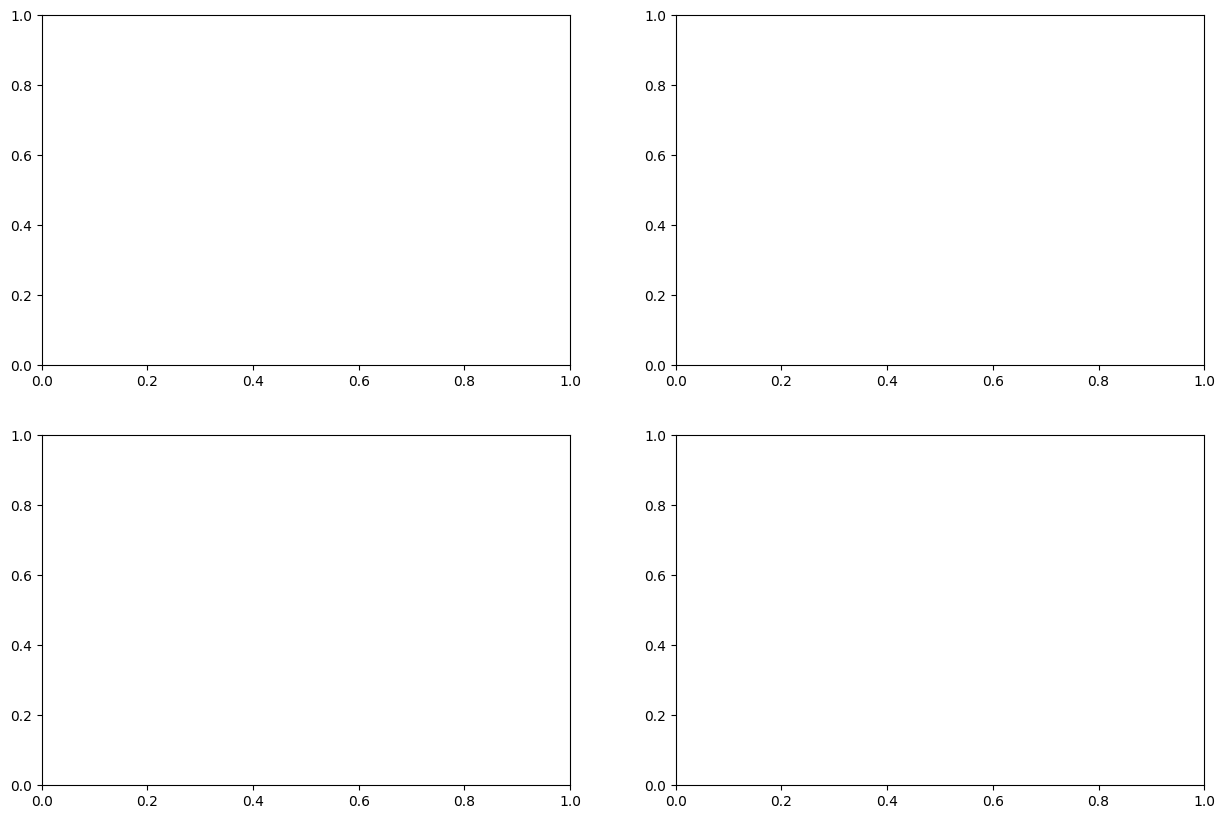

In [ ]:
# ===== Plot Training History =====

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss')
axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# AUC
axes[0, 1].plot(history.history['auc'], label='Train AUC')
axes[0, 1].plot(history.history['val_auc'], label='Val AUC')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].set_title('Training and Validation AUC')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train Precision')
axes[1, 0].plot(history.history['val_precision'], label='Val Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Training and Validation Precision')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train Recall')
axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].set_title('Training and Validation Recall')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, 'training_history.png'), dpi=150)
plt.show()

In [ ]:
# ===== Evaluate on Test Set =====
from sklearn.metrics import classification_report, roc_auc_score, f1_score, hamming_loss

# Get predictions
y_pred_proba = model.predict(X_test, batch_size=BATCH_SIZE)
y_pred = (y_pred_proba > 0.5).astype(int)

# Overall metrics
print("="*50)
print("OVERALL TEST SET METRICS")
print("="*50)

# Hamming Loss (fraction of wrong labels)
hamming = hamming_loss(y_test, y_pred)
print(f"Hamming Loss: {hamming:.4f}")

# Subset Accuracy (exact match)
subset_accuracy = np.mean(np.all(y_test == y_pred, axis=1))
print(f"Subset Accuracy (Exact Match): {subset_accuracy:.4f}")

# F1 Scores
f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"\nF1 Score (Micro): {f1_micro:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")

# ROC-AUC per class
try:
    roc_auc_micro = roc_auc_score(y_test, y_pred_proba, average='micro')
    roc_auc_macro = roc_auc_score(y_test, y_pred_proba, average='macro')
    print(f"\nROC-AUC (Micro): {roc_auc_micro:.4f}")
    print(f"ROC-AUC (Macro): {roc_auc_macro:.4f}")
except ValueError as e:
    print(f"\nROC-AUC calculation failed: {e}")

print("\n" + "="*50)
print("PER-CLASS METRICS")
print("="*50)

# Per-class performance
from sklearn.metrics import precision_score, recall_score

for idx, disease in enumerate(TARGET_DISEASES):
    y_true_class = y_test[:, idx]
    y_pred_class = y_pred[:, idx]
    
    # Only calculate if there are positive samples
    if y_true_class.sum() > 0:
        precision = precision_score(y_true_class, y_pred_class, zero_division=0)
        recall = recall_score(y_true_class, y_pred_class, zero_division=0)
        f1 = f1_score(y_true_class, y_pred_class, zero_division=0)
        
        try:
            roc_auc = roc_auc_score(y_true_class, y_pred_proba[:, idx])
        except ValueError:
            roc_auc = 0.0
        
        support = int(y_true_class.sum())
        
        print(f"\n{disease}:")
        print(f"  Support: {support}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-Score: {f1:.4f}")
        print(f"  ROC-AUC: {roc_auc:.4f}")
    else:
        print(f"\n{disease}: No samples in test set")

NameError: name 'model' is not defined

NameError: name 'y_test' is not defined

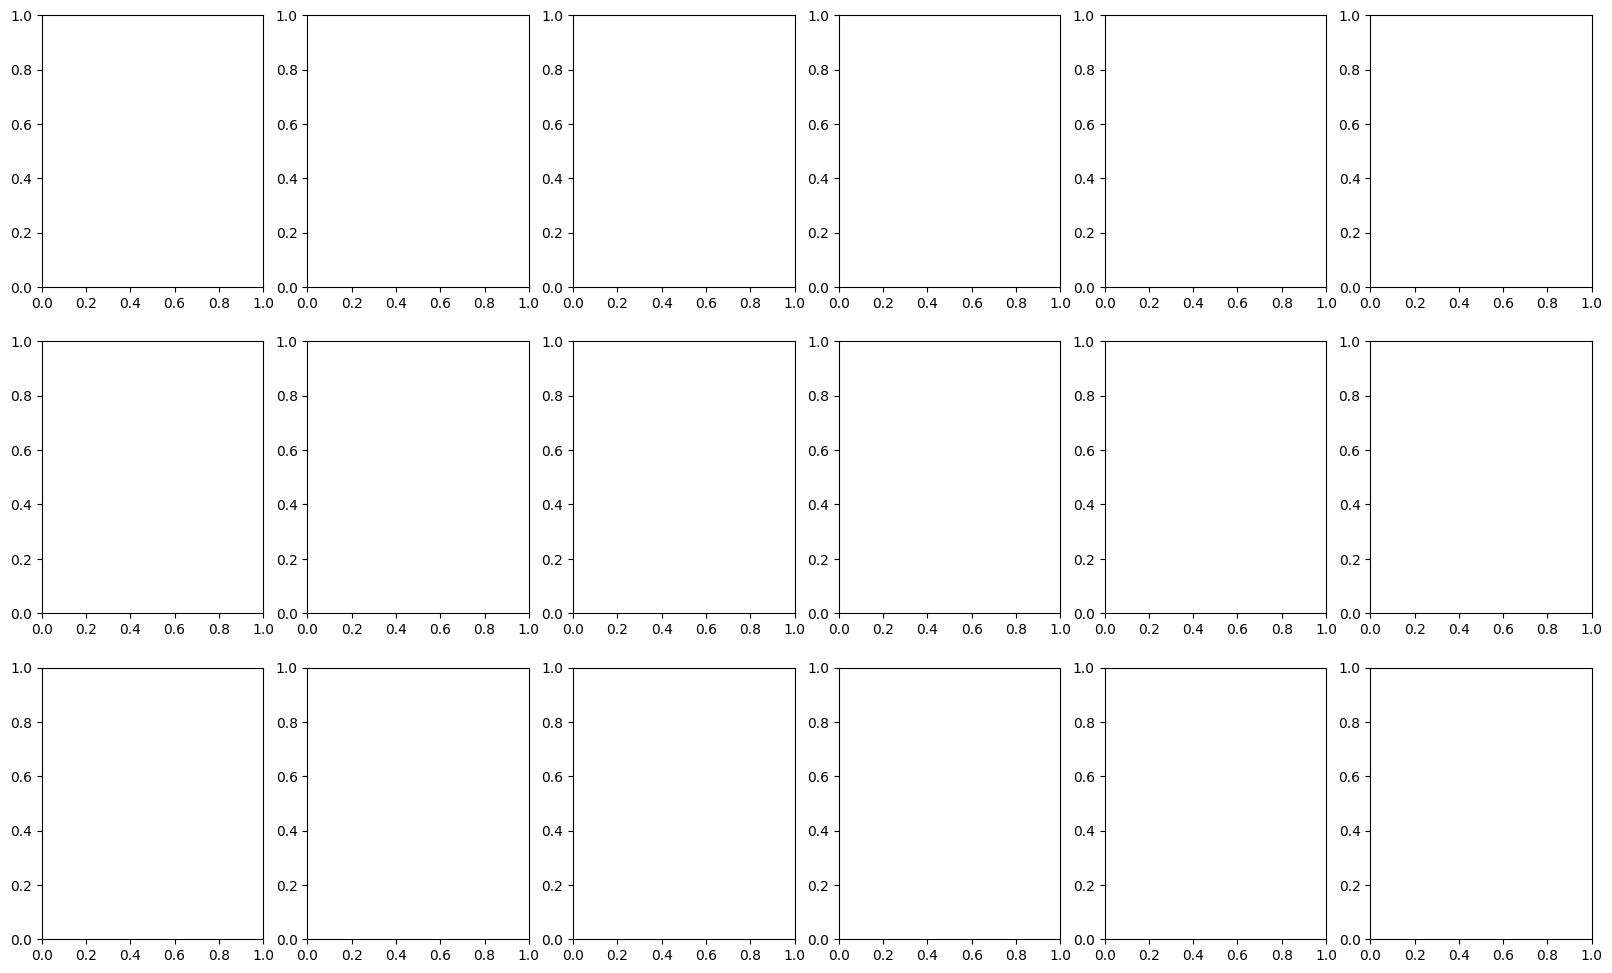

In [ ]:
# ===== Plot ROC Curves for Each Disease =====
from sklearn.metrics import roc_curve, auc

fig, axes = plt.subplots(3, 6, figsize=(20, 12))
axes = axes.ravel()

for idx, disease in enumerate(TARGET_DISEASES):
    y_true_class = y_test[:, idx]
    y_score_class = y_pred_proba[:, idx]
    
    if y_true_class.sum() > 0 and len(np.unique(y_true_class)) > 1:
        fpr, tpr, _ = roc_curve(y_true_class, y_score_class)
        roc_auc = auc(fpr, tpr)
        
        axes[idx].plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
        axes[idx].plot([0, 1], [0, 1], 'k--', label='Random')
        axes[idx].set_xlabel('False Positive Rate')
        axes[idx].set_ylabel('True Positive Rate')
        axes[idx].set_title(f'{disease}\n(n={int(y_true_class.sum())})', fontsize=9)
        axes[idx].legend(fontsize=8)
        axes[idx].grid(True, alpha=0.3)
    else:
        axes[idx].text(0.5, 0.5, 'No positive\nsamples', 
                      ha='center', va='center', fontsize=10)
        axes[idx].set_title(disease, fontsize=9)
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])

plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, 'roc_curves.png'), dpi=150)
plt.show()

In [ ]:
# ===== Example Predictions =====

# Find some interesting examples from the test set
def show_predictions(indices, X_data, y_true, y_pred_proba, threshold=0.5):
    """Show predictions for specific samples"""
    
    for i, idx in enumerate(indices):
        print(f"\n{'='*70}")
        print(f"Sample {idx + 1}")
        print(f"{'='*70}")
        
        true_labels = [TARGET_DISEASES[j] for j in range(len(TARGET_DISEASES)) if y_true[idx, j] == 1]
        pred_proba = y_pred_proba[idx]
        pred_labels = [(TARGET_DISEASES[j], pred_proba[j]) 
                      for j in range(len(TARGET_DISEASES)) if pred_proba[j] > threshold]
        
        print(f"\nTrue Labels ({len(true_labels)}):")
        if true_labels:
            for label in true_labels:
                print(f"  - {label}")
        else:
            print("  - No diseases")
        
        print(f"\nPredicted Labels (threshold={threshold}):")
        if pred_labels:
            for label, prob in sorted(pred_labels, key=lambda x: x[1], reverse=True):
                print(f"  - {label}: {prob:.4f}")
        else:
            print("  - No diseases predicted")
        
        # Show top predictions even if below threshold
        print(f"\nTop 5 Predictions (all):")
        top_predictions = sorted(enumerate(pred_proba), key=lambda x: x[1], reverse=True)[:5]
        for disease_idx, prob in top_predictions:
            marker = "✓" if y_true[idx, disease_idx] == 1 else " "
            print(f"  {marker} {TARGET_DISEASES[disease_idx]}: {prob:.4f}")

# Show some examples with multiple diseases
multi_disease_indices = np.where(y_test.sum(axis=1) >= 2)[0][:3]
print("Examples with Multiple Diseases:")
show_predictions(multi_disease_indices, X_test, y_test, y_pred_proba)

# Show some examples with single disease
single_disease_indices = np.where(y_test.sum(axis=1) == 1)[0][:3]
print("\n\nExamples with Single Disease:")
show_predictions(single_disease_indices, X_test, y_test, y_pred_proba)

NameError: name 'y_test' is not defined

In [ ]:
# ===== Visualize ECG Signals with Predictions =====

def plot_ecg_with_predictions(idx, X_data, y_true, y_pred_proba, num_leads_to_show=3):
    """Plot ECG signal with true and predicted labels"""
    
    ecg_signal = X_data[idx]
    true_labels = [TARGET_DISEASES[j] for j in range(len(TARGET_DISEASES)) if y_true[idx, j] == 1]
    pred_proba = y_pred_proba[idx]
    pred_labels = [(TARGET_DISEASES[j], pred_proba[j]) 
                  for j in range(len(TARGET_DISEASES)) if pred_proba[j] > 0.5]
    
    # Plot first few leads
    fig, axes = plt.subplots(num_leads_to_show, 1, figsize=(15, 8))
    
    lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    
    for i in range(min(num_leads_to_show, ecg_signal.shape[1])):
        if num_leads_to_show == 1:
            ax = axes
        else:
            ax = axes[i]
        
        ax.plot(ecg_signal[:, i], linewidth=0.5)
        lead_name = lead_names[i] if i < len(lead_names) else f'Lead {i+1}'
        ax.set_ylabel(f'{lead_name}', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, len(ecg_signal))
        
        if i == 0:
            title = f'Sample {idx} - ECG Signal\n'
            title += f'True: {", ".join(true_labels) if true_labels else "No disease"}\n'
            if pred_labels:
                title += f'Predicted: {", ".join([f"{l} ({p:.2f})" for l, p in pred_labels])}'
            else:
                title += 'Predicted: No disease'
            ax.set_title(title, fontsize=11, pad=10)
        
        if i == num_leads_to_show - 1:
            ax.set_xlabel('Time (samples @ 500 Hz)', fontsize=10)
    
    plt.tight_layout()
    return fig

# Plot a few interesting examples
interesting_indices = [0, 5, 10]  # You can change these
for idx in interesting_indices:
    if idx < len(X_test):
        fig = plot_ecg_with_predictions(idx, X_test, y_test, y_pred_proba, num_leads_to_show=3)
        plt.savefig(os.path.join(ARTIFACT_DIR, f'ecg_prediction_sample_{idx}.png'), dpi=150, bbox_inches='tight')
        plt.show()
        plt.close()

NameError: name 'X_test' is not defined

## How to Use the Trained Model for Inference

The trained model can be used to predict cardiovascular diseases from new ECG data. Here's a complete example:

```python
import numpy as np
import tensorflow as tf
import wfdb
import json

# 1. Load the saved model
model = tf.keras.models.load_model('path/to/final_model.keras')

# 2. Load the label mapping
with open('path/to/label_mapping.json', 'r') as f:
    label_mapping = json.load(f)
idx_to_disease = {int(k): v for k, v in label_mapping['idx_to_disease'].items()}

# 3. Load and preprocess a new ECG signal
# (Use the same preprocess_ecg_signal function defined above)
ecg_record = wfdb.rdsamp('path/to/ecg/file')[0]
ecg_processed = preprocess_ecg_signal(ecg_record, target_length=5000)

# 4. Make prediction
ecg_input = np.expand_dims(ecg_processed, axis=0)  # Add batch dimension
predictions = model.predict(ecg_input)[0]

# 5. Interpret results (using 0.5 as threshold)
threshold = 0.5
predicted_diseases = []
for idx, prob in enumerate(predictions):
    if prob > threshold:
        predicted_diseases.append({
            'disease': idx_to_disease[idx],
            'probability': float(prob)
        })

# Sort by probability
predicted_diseases.sort(key=lambda x: x['probability'], reverse=True)

print("Predicted Diseases:")
for pred in predicted_diseases:
    print(f"  {pred['disease']}: {pred['probability']:.4f}")
```

### Key Points:
- The model expects input shape: (batch_size, 5000, num_leads)
- All signals must be preprocessed using the same method as training
- Use sigmoid threshold (typically 0.5) for multi-label classification
- The model outputs probabilities for each of the 18 target diseases

In [ ]:
# ===== Save Model and Create Summary Report =====

# Save the final model
model.save(os.path.join(ARTIFACT_DIR, 'final_model.keras'))
print(f"Model saved to: {os.path.join(ARTIFACT_DIR, 'final_model.keras')}")

# Save label mapping
import json
label_mapping = {
    'disease_to_idx': disease_to_idx,
    'idx_to_disease': {str(k): v for k, v in idx_to_disease.items()},
    'target_diseases': TARGET_DISEASES
}

with open(os.path.join(ARTIFACT_DIR, 'label_mapping.json'), 'w') as f:
    json.dump(label_mapping, f, indent=2)
print(f"Label mapping saved to: {os.path.join(ARTIFACT_DIR, 'label_mapping.json')}")

# Create a summary report
summary_report = {
    'model_architecture': '1D CNN with Residual Connections',
    'input_shape': input_shape,
    'num_classes': num_classes,
    'target_length': TARGET_LENGTH,
    'sampling_rate': 500,
    'batch_size': BATCH_SIZE,
    'epochs_trained': len(history.history['loss']),
    'dataset_splits': {
        'train': len(X_train),
        'val': len(X_val),
        'test': len(X_test),
        'total': len(X_processed)
    },
    'test_metrics': {
        'hamming_loss': float(hamming),
        'subset_accuracy': float(subset_accuracy),
        'f1_micro': float(f1_micro),
        'f1_macro': float(f1_macro),
        'f1_weighted': float(f1_weighted)
    }
}

with open(os.path.join(ARTIFACT_DIR, 'model_summary.json'), 'w') as f:
    json.dump(summary_report, f, indent=2)
print(f"Summary report saved to: {os.path.join(ARTIFACT_DIR, 'model_summary.json')}")

print("\n" + "="*70)
print("TRAINING AND EVALUATION COMPLETE!")
print("="*70)
print(f"\nAll artifacts saved to: {ARTIFACT_DIR}")
print("\nGenerated files:")
print("  - best_model.keras (best model during training)")
print("  - final_model.keras (final model)")
print("  - training_log.csv (training history)")
print("  - training_history.png (training curves)")
print("  - roc_curves.png (ROC curves for each disease)")
print("  - ecg_prediction_sample_*.png (sample predictions)")
print("  - label_mapping.json (disease label mapping)")
print("  - model_summary.json (model and performance summary)")

NameError: name 'model' is not defined